### Problem Definition

### Objective: 
Build a system that can classify whether an essay is AI-generated or human-written, and explain the decision.

### Why it matters: 
With the rise of AI writing tools, schools, publishers, and businesses need reliable ways to identify authorship.

In [15]:
# Install dependencies as needed:
#!pip install kagglehub

In [146]:
# !pip install textstat

     ------------------------------------ 239.2/239.2 kB 814.7 kB/s eta 0:00:00
     ---------------------------------------- 2.1/2.1 MB 1.7 MB/s eta 0:00:00


# Importing Libraries

In [41]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb

import textstat   # readability scores
import joblib

# Data Loading

In [2]:
import kagglehub

# -----------------------------
# Download dataset
# -----------------------------

path = kagglehub.dataset_download("navjotkaushal/human-vs-ai-generated-essays")


In [3]:
# -----------------------------
# Load CSV into pandas
# -----------------------------

data = pd.read_csv(f"{path}/balanced_ai_human_prompts.csv")

In [4]:
# Converting into DataFrame

df = pd.DataFrame(data)

In [5]:
df.sample(2)

,text,generated
872,Reducing the amount of cars used would benefit...,0
1978,Draft a technical report analyzing 5G network ...,1


## Data Preprocessing

In [6]:
# checking shape

df.shape

(2750, 2)

In [7]:
# checking for null values

df.isnull().sum()

text         0
generated    0
dtype: int64

In [8]:
# checking for duplicate values

df.duplicated().sum()

330

In [9]:
# dropping duplicated values

df.drop_duplicates(inplace = True)

In [10]:
df.duplicated().sum()

0

In [11]:
df.shape

(2420, 2)

In [12]:
# checking classes -> balanced or imbalanced

df['generated'].value_counts()

generated
0    1375
1    1045
Name: count, dtype: int64

## Text Preview

In [13]:
# Preview of texts
# \033[1m -> bold text
# \033[0m -> reset all formatting (back to normal)

print("\033[1m \nSample texts:\033[0m  \n")

print("\033[1mHuman text preview: \033[0m")
print(df[df["generated"] == 0]['text'].iloc[0][:300] + "...\n")

# .iloc[0] → Gets the first essay from that Series (row index 0).


print("\033[1mAI text preview: \033[0m")
print(df[df["generated"] == 1]['text'].iloc[0][:300] + "...\n")

 
Sample texts:  

Human text preview: 
Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of car...

AI text preview: 
Machine learning, a subset of artificial intelligence, has rapidly emerged as a transformative force, revolutionizing industries and redefining the possibilities of technology. At its core, machine learning enables computers to learn from data and make informed decisions without explicit programming...



In [14]:
df[df["generated"] == 0]["text"].sample(1).values[0][:200]

'There are many advantages to limiting car usage. The whole world has already figured that out. Many countries are now starting to limit the car usage. It is a good idea to limit the car usage because '

### Lowercasing, removing punctuations and Tokenization

In [15]:
#  Download NLTK data (only once)

# nltk.download("punkt")

In [16]:
def preprocess_text(text):
    
    """
    Preprocess text by:
    1. Lowercasing
    2. Removing punctuation
    3. Tokenizing into words
    """
    # 1. Lowercase
    text = text.lower()
    
    # 2. remove punctions
    text = re.sub(r"[^a-z\s]", "", text)
    
    # 3. word tokenize
    tokens = word_tokenize(text)
    
    return tokens


In [17]:
# Apply function to dataset

df["tokens"] = df["text"].apply(preprocess_text)

In [18]:
df.head(2)

,text,generated,tokens
0,"Machine learning, a subset of artificial intel...",1,"[machine, learning, a, subset, of, artificial,..."
1,"A decision tree, a prominent machine learning ...",1,"[a, decision, tree, a, prominent, machine, lea..."


In [19]:
print(df[["text", "tokens"]].iloc[0])

text      Machine learning, a subset of artificial intel...
tokens    [machine, learning, a, subset, of, artificial,...
Name: 0, dtype: object


In [20]:
print("Original Text:\n", df["text"].iloc[0][:20])   # first 20 characters of essay
print("\nTokens:\n", df["tokens"].iloc[0][:20])      # first 20 tokens

Original Text:
 Machine learning, a 

Tokens:
 ['machine', 'learning', 'a', 'subset', 'of', 'artificial', 'intelligence', 'has', 'rapidly', 'emerged', 'as', 'a', 'transformative', 'force', 'revolutionizing', 'industries', 'and', 'redefining', 'the', 'possibilities']


# Exploratory Data Analysis (EDA)

In [126]:
# Word Count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Character Count
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

In [127]:
df.head()

,text,generated,tokens,word_count,char_count
0,"Machine learning, a subset of artificial intel...",1,"[machine, learning, a, subset, of, artificial,...",96,722
1,"A decision tree, a prominent machine learning ...",1,"[a, decision, tree, a, prominent, machine, lea...",103,774
2,"Education, a cornerstone of societal progress,...",1,"[education, a, cornerstone, of, societal, prog...",93,757
3,"Computers, the backbone of modern technology, ...",1,"[computers, the, backbone, of, modern, technol...",92,718
4,"Chess, a timeless game of strategy and intelle...",1,"[chess, a, timeless, game, of, strategy, and, ...",110,827


## Distribution Plots

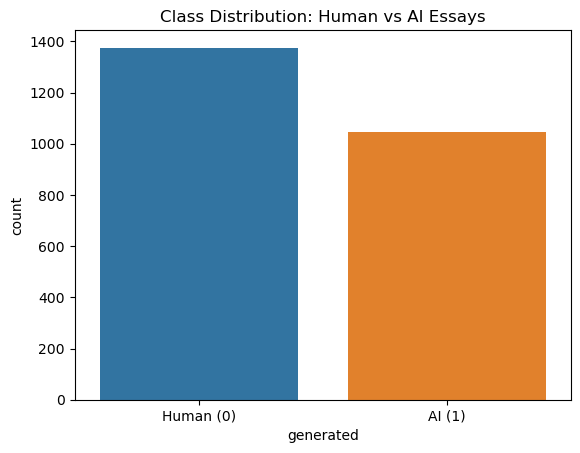

In [128]:
sns.countplot(x="generated", data=df)
plt.title("Class Distribution: Human vs AI Essays")
plt.xticks([0,1], ["Human (0)", "AI (1)"])
plt.show()


### word_count distribution

C:\Users\PC\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\PC\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\PC\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

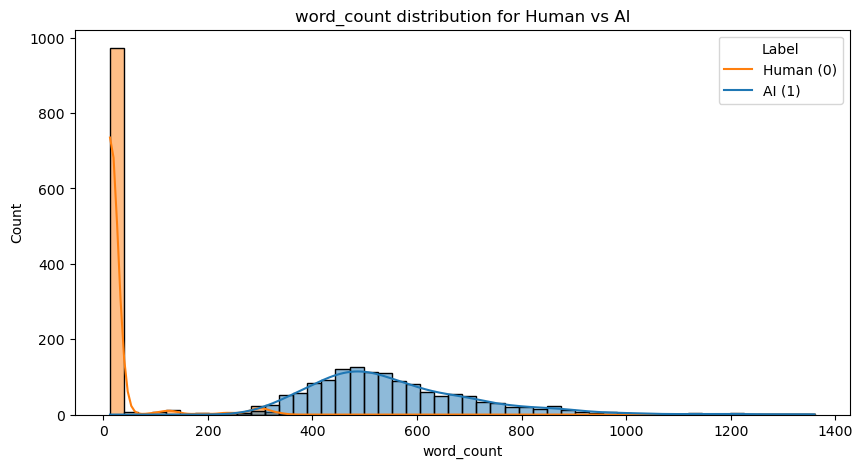

In [129]:
# Plot word_count distribution for Human vs AI

plt.figure(figsize=(10,5))
sns.histplot(data=df, x="word_count", hue="generated", bins=50, kde = True)
plt.title("word_count distribution for Human vs AI")
plt.legend(title="Label", labels=["Human (0)", "AI (1)"])

### character count distribution

C:\Users\PC\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\PC\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\PC\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

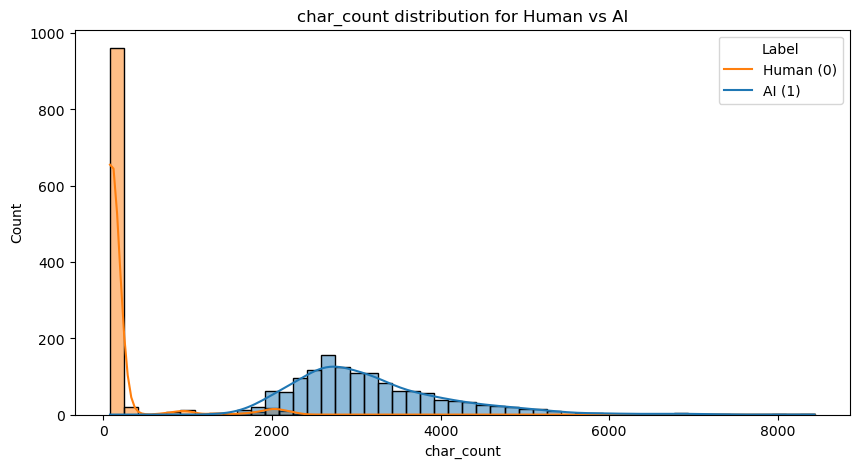

In [130]:
# Plot char_count distribution for Human vs AI

plt.figure(figsize=(10,5))
sns.histplot(data=df, x="char_count", hue="generated", bins=50, kde = True)
plt.title("char_count distribution for Human vs AI")
plt.legend(title="Label", labels=["Human (0)", "AI (1)"])

### Average Essay Length (Comparison)

In [131]:
print("Average Word Count per Class:\n")
print(df.groupby("generated")["word_count"].mean())
print("\n..........................................\n")

print("\nAverage Character Count per Class:\n")
print(df.groupby("generated")["char_count"].mean())

Average Word Count per Class:

generated
0    556.768727
1     27.956938
Name: word_count, dtype: float64

..........................................


Average Character Count per Class:

generated
0    3172.581091
1     191.206699
Name: char_count, dtype: float64


## Word Frequency Analysis (Top Words per Class)

In [132]:
from nltk.corpus import stopwords

# nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

df["no_stop_word_tokens"] = df["tokens"].apply(lambda x: [w for w in x if w not in stop_words])


In [133]:
df.head(3)

,text,generated,tokens,word_count,char_count,no_stop_word_tokens
0,"Machine learning, a subset of artificial intel...",1,"[machine, learning, a, subset, of, artificial,...",96,722,"[machine, learning, subset, artificial, intell..."
1,"A decision tree, a prominent machine learning ...",1,"[a, decision, tree, a, prominent, machine, lea...",103,774,"[decision, tree, prominent, machine, learning,..."
2,"Education, a cornerstone of societal progress,...",1,"[education, a, cornerstone, of, societal, prog...",93,757,"[education, cornerstone, societal, progress, e..."


In [134]:
from collections import Counter

# Flatten tokens into single list for each class
human_words = [word for tokens in df[df['generated'] == 0]['no_stop_word_tokens'] for word in tokens]
ai_words = [word for tokens in df[df['generated'] == 1]['no_stop_word_tokens'] for word in tokens]

# Count frequencies
human_freq = Counter(human_words).most_common(20)
ai_freq = Counter(ai_words).most_common(20)

print("Top 20 Human words:\n", human_freq)
print("\nTop 20 AI words:\n", ai_freq)

Top 20 Human words:
 [('electoral', 7221), ('people', 6777), ('college', 6027), ('vote', 5969), ('car', 5850), ('cars', 5740), ('states', 4168), ('would', 3771), ('president', 3554), ('votes', 2523), ('electors', 2501), ('usage', 2444), ('many', 2419), ('one', 2353), ('popular', 2285), ('also', 2066), ('even', 2049), ('pollution', 1980), ('get', 1961), ('election', 1958)]

Top 20 AI words:
 [('context', 961), ('global', 171), ('exploration', 166), ('education', 155), ('world', 138), ('technology', 136), ('environmental', 122), ('essay', 115), ('key', 110), ('modern', 109), ('public', 108), ('developing', 108), ('technological', 107), ('life', 106), ('provide', 106), ('draft', 106), ('technical', 106), ('report', 106), ('analyzing', 106), ('sustainability', 104)]


## Word Cloud Visualization 🌩️

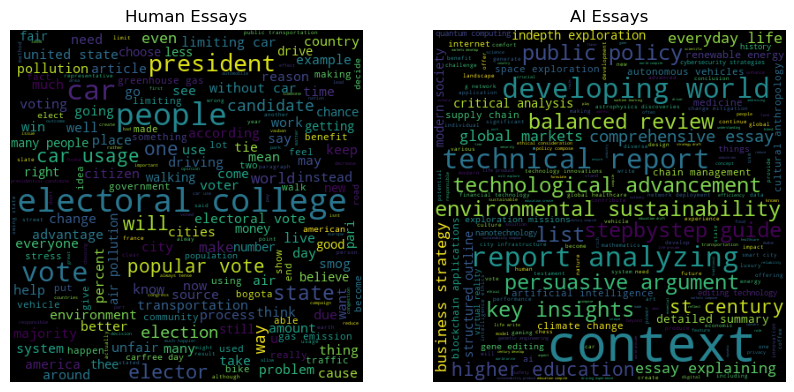

In [135]:
from wordcloud import WordCloud

# combine all human-written essays into one big string (human_text) and all AI-written essays into another (ai_text)

human_text = " ".join([" ".join(tokens) for tokens in df[df['generated']==0]['tokens']])
ai_text = " ".join([" ".join(tokens) for tokens in df[df['generated']==1]['tokens']])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=400, height=400, background_color="black").generate(human_text))
plt.title("Human Essays")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=400, height=400, background_color="black").generate(ai_text))
plt.title("AI Essays")
plt.axis("off")

plt.show()


# Linguistic Features Extraction

### linguistic, syntactic, and stylistic features

In [21]:
import numpy as np
import nltk
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from nltk.tokenize import sent_tokenize

# Make sure you have these downloaded at least once:
# nltk.download('punkt')
# nltk.download('stopwords')
# Try both tagger names
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

stop_words = set(stopwords.words("english"))
contractions = set(["'s","'ve","'re","n't","'ll","'d","'m"])

def extract_advanced_features(text):
    features = {}
    
    # Tokenization
    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    total_words = len(words)
    total_sentences = len(sentences) if sentences else 1
    
    # --- Lexical Features ---
    features["avg_word_len"] = np.mean([len(w) for w in words]) if words else 0
    features["vocab_richness"] = len(set(words)) / total_words if total_words > 0 else 0
    word_counts = Counter(words)
    hapax_legomena = [w for w, c in word_counts.items() if c == 1]
    features["hapax_ratio"] = len(hapax_legomena) / total_words if total_words > 0 else 0
    
    # --- Syntactic Features ---
    pos_tags = pos_tag(words)
    pos_counts = Counter(tag for _, tag in pos_tags)
    total_pos = sum(pos_counts.values()) if pos_counts else 1
    features["noun_ratio"] = pos_counts.get("NN", 0) / total_pos
    features["verb_ratio"] = pos_counts.get("VB", 0) / total_pos
    features["adj_ratio"] = pos_counts.get("JJ", 0) / total_pos
    features["adv_ratio"] = pos_counts.get("RB", 0) / total_pos
    
    # Sentence structure
    sentence_lengths = [len(word_tokenize(s)) for s in sentences]
    features["avg_sentence_len"] = np.mean(sentence_lengths) if sentence_lengths else 0
    features["sentence_len_var"] = np.var(sentence_lengths) if len(sentence_lengths) > 1 else 0  # burstiness
    
    # --- Stylistic Features ---
    features["punctuation_ratio"] = sum(1 for w in words if re.match(r"[^\w\s]", w)) / total_words if total_words > 0 else 0
    features["stopword_ratio"] = sum(1 for w in words if w.lower() in stop_words) / total_words if total_words > 0 else 0
    features["contraction_ratio"] = sum(1 for w in words if w.lower() in contractions) / total_words if total_words > 0 else 0
    
    # --- Repetition Features ---
    repeated_phrases = sum(1 for w, c in word_counts.items() if c > 3)
    features["repetition_ratio"] = repeated_phrases / len(word_counts) if word_counts else 0
    
    return features


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [22]:
linguistic_features = df["text"].apply(extract_advanced_features)

df_features = pd.concat(
    [df.reset_index(drop=True), pd.DataFrame(linguistic_features.tolist()).reset_index(drop=True)],
    axis=1
)



In [23]:
df_features.head(3)

,text,generated,tokens,avg_word_len,vocab_richness,hapax_ratio,noun_ratio,verb_ratio,adj_ratio,adv_ratio,avg_sentence_len,sentence_len_var,punctuation_ratio,stopword_ratio,contraction_ratio,repetition_ratio
0,"Machine learning, a subset of artificial intel...",1,"[machine, learning, a, subset, of, artificial,...",5.598214,0.678571,0.580357,0.232143,0.026786,0.080357,0.008929,28.0,8.500000,0.142857,0.303571,0.0,0.092105
1,"A decision tree, a prominent machine learning ...",1,"[a, decision, tree, a, prominent, machine, lea...",5.600000,0.716667,0.608333,0.191667,0.008333,0.100000,0.008333,20.0,22.333333,0.141667,0.250000,0.0,0.058140
2,"Education, a cornerstone of societal progress,...",1,"[education, a, cornerstone, of, societal, prog...",5.833333,0.684211,0.578947,0.184211,0.008772,0.166667,0.008772,22.8,27.360000,0.184211,0.210526,0.0,0.038462


In [24]:
df_features.shape

(2420, 16)

# Splitting Data

In [25]:
print(df_features["generated"].isna().sum())   # check NaNs after concat
print(df_features[df_features["generated"].isna()].head())  # see bad rows
print(df.shape, df_features.shape)  # compare sizes


0
Empty DataFrame
Columns: [text, generated, tokens, avg_word_len, vocab_richness, hapax_ratio, noun_ratio, verb_ratio, adj_ratio, adv_ratio, avg_sentence_len, sentence_len_var, punctuation_ratio, stopword_ratio, contraction_ratio, repetition_ratio]
Index: []
(2420, 3) (2420, 16)


In [26]:

X = df_features["text"]
y = df_features["generated"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((1936,), (484,), (1936,), (484,))

# Vectorization (TF-IDF)

In [28]:
tfidf = TfidfVectorizer(max_features = 5000, stop_words = "english")

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [29]:
X_train_tfidf

<1936x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 173916 stored elements in Compressed Sparse Row format>

In [30]:
from scipy.sparse import hstack

# Get linguistic features
X_train_ling = df_features.loc[X_train.index, df_features.columns.difference(['text','tokens','generated','no_stop_word_tokens'])].values
X_test_ling  = df_features.loc[X_test.index,  df_features.columns.difference(['text','tokens','generated','no_stop_word_tokens'])].values

# Combine
X_train_final = hstack([X_train_tfidf, X_train_ling])
X_test_final  = hstack([X_test_tfidf,  X_test_ling])


# Modelling

In [32]:
# ✅ Unified evaluation function
def evaluate_model_fixed(model, X_train, y_train, X_test, y_test, name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n===== {name} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return model


# ✅ Train models with correct features
# Logistic Regression (uses TF-IDF + linguistic)
lr = LogisticRegression(max_iter=1000)
lr = evaluate_model_fixed(lr, X_train_final, y_train, X_test_final, y_test, "Logistic Regression")

# Random Forest (TF-IDF only for speed)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf = evaluate_model_fixed(rf, X_train_final, y_train, X_test_final, y_test, "Random Forest")

# XGBoost (TF-IDF only)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_clf = evaluate_model_fixed(xgb_clf, X_train_final, y_train, X_test_final, y_test, "XGBoost")

# Naive Bayes (TF-IDF only)
nb = MultinomialNB()
nb = evaluate_model_fixed(nb, X_train_final, y_train, X_test_final, y_test, "Naive Bayes")



===== Logistic Regression =====
Accuracy: 0.9979338842975206

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       275
           1       1.00      1.00      1.00       209

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484

Confusion Matrix:
 [[275   0]
 [  1 208]]

===== Random Forest =====
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       275
           1       1.00      1.00      1.00       209

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484

Confusion Matrix:
 [[275   0]
 [  0 209]]


C:\Users\PC\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [17:23:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



===== XGBoost =====
Accuracy: 0.9979338842975206

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       275
           1       1.00      1.00      1.00       209

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484

Confusion Matrix:
 [[275   0]
 [  1 208]]

===== Naive Bayes =====
Accuracy: 0.9834710743801653

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       275
           1       1.00      0.96      0.98       209

    accuracy                           0.98       484
   macro avg       0.99      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484

Confusion Matrix:
 [[275   0]
 [  8 201]]


# Testing on String outside of this data

In [39]:
import string

# --- Preprocessing function ---
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

def predict_text_combined_fixed(text, model, vectorizer, name):
    clean_text = preprocess_text(text)
    
    # TF-IDF
    text_tfidf = vectorizer.transform([clean_text]).toarray()
    
    # Linguistic features
    ling_feats = extract_advanced_features(text)
    ling_feats = pd.DataFrame([ling_feats]).values
    
    # Combine
    final_features = np.hstack([text_tfidf, ling_feats])
    
    # Predict
    prediction = model.predict(final_features)[0]
    proba = model.predict_proba(final_features)[0]
    
    label = "Human-written" if prediction == 0 else "AI-generated"
    
    print(f"\n.......................{name}..................\n")
    print(f"\n📝 Input text: {text[:200]}{'...' if len(text) > 200 else ''}")
    print(f"🔮 Prediction: {label}")
    print(f"📊 Confidence -> Human: {proba[0]:.4f}, AI: {proba[1]:.4f}")
    print("\n")
    return label


In [40]:
sample_text = """Re-enable your linguistic features (sentence length, vocab richness, readability, stopword ratio, etc.) and combine them with TF-IDF.

Try n-grams (bigrams/trigrams) in TF-IDF, since AI text often has repeated phrase structures.

Consider deep learning baselines (like DistilBERT or RoBERTa fine-tuning). That way you can compare classic ML vs transformers.
"""



predict_text_combined_fixed(sample_text, nb, tfidf, "Naive Bayes")
predict_text_combined_fixed(sample_text, lr, tfidf,"Logistic Regression")
predict_text_combined_fixed(sample_text, rf, tfidf,"Random Classifier")
predict_text_combined_fixed(sample_text, xgb_clf, tfidf,"XGBoost")



.......................Naive Bayes..................


📝 Input text: Re-enable your linguistic features (sentence length, vocab richness, readability, stopword ratio, etc.) and combine them with TF-IDF.

Try n-grams (bigrams/trigrams) in TF-IDF, since AI text often has...
🔮 Prediction: AI-generated
📊 Confidence -> Human: 0.4003, AI: 0.5997



.......................Logistic Regression..................


📝 Input text: Re-enable your linguistic features (sentence length, vocab richness, readability, stopword ratio, etc.) and combine them with TF-IDF.

Try n-grams (bigrams/trigrams) in TF-IDF, since AI text often has...
🔮 Prediction: Human-written
📊 Confidence -> Human: 1.0000, AI: 0.0000



.......................Random Classifier..................


📝 Input text: Re-enable your linguistic features (sentence length, vocab richness, readability, stopword ratio, etc.) and combine them with TF-IDF.

Try n-grams (bigrams/trigrams) in TF-IDF, since AI text often has...
🔮 Prediction: Human-w

'Human-written'

# Saving model and vectorizer

In [42]:
joblib.dump(nb, "naive_bayes.pkl")

['naive_bayes.pkl']

In [43]:
joblib.dump(tfidf, "tfidf.pkl")

['tfidf.pkl']